In [22]:
import os
import random
import time
from datetime import datetime
from pathlib import Path

import evaluate
import numpy as np
import PIL.Image as pil_image
import torch
import typst
from datasets import ClassLabel, DatasetDict, Features, Image, Value, load_dataset
from huggingface_hub import snapshot_download
from joblib import Parallel, delayed
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from transformers import (
    AutoImageProcessor,
    AutoTokenizer,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    TrainerCallback,
    TrOCRForCausalLM,
    TrOCRProcessor,
    VisionEncoderDecoderModel,
    default_data_collator,
    get_linear_schedule_with_warmup,
    EarlyStoppingCallback,
)

from typstscribe.const import DATA_DIR, LOGS_DIR, MODULE_DIR, PROJECT_DIR, MODELS_DIR, TOKENIZER_MODELS_DIR
from typstscribe.image import convert_to_rgb_white_bg
from typstscribe.typst import TypstGrayscaleCompiler

from enum import Enum

In [23]:
PRETRAINED_MODEL = "microsoft/trocr-small-stage1"  # We use stage1 instead of printed for better generalization
TEXT_COLUMN = "typst"  # Or "latex" if we wanted to do LaTeX OCR

# Download Dataset

In [24]:
# Save a local copy of the entire dataset
dataset_path = Path(
    snapshot_download(
        repo_id="JeppeKlitgaard/typst-image-dataset",
        repo_type="dataset",
    )
)
display(dataset_path)

Fetching 354 files:   0%|          | 0/354 [00:00<?, ?it/s]

PosixPath('/home/jkl/.cache/huggingface/hub/datasets--JeppeKlitgaard--typst-image-dataset/snapshots/e855cf9b802ae2ac3b962f36f76f34977bd94155')

In [ ]:
# Extract features and do basic filtering
# We only keep printed images for this model
features = Features(
    {
        "image": Image(),
        "latex.txt": Value("string"),
        "typst.txt": Value("string"),
        "metadata.json": {
            "image_type": ClassLabel(names=["handwritten", "printed"]),
            "image_extension": ClassLabel(names=["png", "jpg", "bmp", "dvi"]),
        },
    }
)

ds = load_dataset(
    "JeppeKlitgaard/typst-image-dataset",
    data_files={
        # "test": "test/*.tar",
        # "train": "train/shard_0001*.tar",
        "train": "train/*.tar",
        "validation": "validation/*.tar",
    },
    # Maybe numproc here?
    features=features,
)
ds = ds.flatten()
ds = ds.rename_columns(
    {
        "typst.txt": "typst",
        "latex.txt": "latex",
        "metadata.json.image_type": "image_type",
        "metadata.json.image_extension": "image_extension",
    }
)
ds = ds.remove_columns(["image_extension"])

_target_image_type_int = features.flatten()["metadata.json.image_type"].str2int(
    "printed"
)


def filter_image_type(image_type_int):
    return image_type_int == _target_image_type_int


ds = ds.filter(
    filter_image_type,
    input_columns=["image_type"],
)  # Filter does not hydrate the class label apparently
ds = ds.remove_columns(["image_type"])
ds

Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'latex', 'typst'],
        num_rows: 943190
    })
    validation: Dataset({
        features: ['image', 'latex', 'typst'],
        num_rows: 1366
    })
})

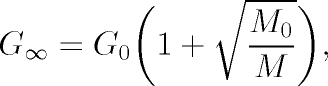

'G _ ( oo ) = G _ ( 0 ) ( 1 + sqrt( ( M _ ( 0 ) ) / ( M ) ) ) ,'

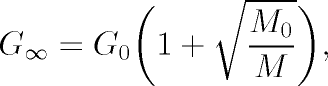

In [26]:
# The HuggingFace Datasets WebDataset loader is a bit wonky to work with, so just validate that
# We are getting the correct data types by having a look here:
display(ds["train"]["image"][0].convert("RGB"))
display(ds["train"]["typst"][0])

display(convert_to_rgb_white_bg(ds["train"]["image"][0]))

In [27]:
# ds = DatasetDict(
#     {
#         "train": ds["train"].take(400_000),
#         # "train": ds["train"].take(100_000),
#         # "train": ds["train"].take(10_000),
#         "validation": ds["validation"].take(1_000),
#     }
# )
# ds

# ds = ds.to_iterable_dataset(num_shards=256)
ds_train = ds["train"].to_iterable_dataset(num_shards=256)

In [28]:
class ProcessorSetup(Enum):
    TYPST_TOKENIZER = "typst_tokenizer"
    DEFAULT= "default"

PROCESSOR_SETUP = ProcessorSetup.TYPST_TOKENIZER


In [29]:
### Processor

match PROCESSOR_SETUP:
    case ProcessorSetup.TYPST_TOKENIZER:
        # Uncomment to use HuggingFace hosted tokenizer instead of local development version
        # Local copy of tokenizer
        # tokenizer_path = "JeppeKlitgaard/typst-tokenizer"
        # snapshot_download(repo_id="JeppeKlitgaard/typst-tokenizer", repo_type="model")

        tokenizer_path = TOKENIZER_MODELS_DIR / "typst_tokenizer"
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

        # Use existing image processor from base model
        image_processor = AutoImageProcessor.from_pretrained(PRETRAINED_MODEL, use_fast=True)

        # Fix for when parallelising the data loaders as well
        os.environ["TOKENIZERS_PARALLELISM"] = "false"

        processor = TrOCRProcessor(
            image_processor=image_processor, tokenizer=tokenizer, use_fast=True
        )

    case ProcessorSetup.DEFAULT:
        processor = TrOCRProcessor.from_pretrained(PRETRAINED_MODEL, use_fast=False)


In [30]:
### Model

MAX_LENGTH = 256  # Sensible, see typst_tokenizer.ipynb
# MAX_LENGTH = (
#     128  # Smaller since we mostly want to prove that the architecture could work
# )

### Model
pretrained_model = VisionEncoderDecoderModel.from_pretrained(PRETRAINED_MODEL)

encoder = pretrained_model.encoder
decoder = pretrained_model.decoder

decoder.config.vocab_size = len(processor.tokenizer)
decoder.config.decoder_start_token_id = processor.tokenizer.cls_token_id
decoder.config.pad_token_id = processor.tokenizer.pad_token_id
decoder.config.eos_token_id = processor.tokenizer.sep_token_id
decoder.config.bos_token_id = processor.tokenizer.cls_token_id

model = VisionEncoderDecoderModel(encoder=encoder, decoder=decoder)

# Definitely some redundant assignments here, but I am afraid of breaking something

# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size
model.decoder.resize_token_embeddings(len(processor.tokenizer))

model.generation_config.max_length = MAX_LENGTH
model.generation_config.early_stopping = True
model.generation_config.no_repeat_ngram_size = 0
# length_penalty: https://huggingface.co/docs/transformers/en/internal/generation_utils
# length_penalty > 0.0: longer sequences are favoured
# length_penalty < 0.0: shorter sequences are favoured
# model.generation_config.length_penalty = 2.0  # Don't set this for now, this matches pix2text-mfr-1.5
model.generation_config.length_penalty = 1.2  # Slightly higher than default 1.0
model.generation_config.repetition_penalty = 1.15  # Disincentivize repetition a bit
model.generation_config.num_beams = 4
model.generation_config.pad_token_id = processor.tokenizer.pad_token_id
model.generation_config.eos_token_id = processor.tokenizer.sep_token_id
model.generation_config.bos_token_id = processor.tokenizer.cls_token_id
model.generation_config.decoder_start_token_id = processor.tokenizer.cls_token_id

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
model.decoder.config

TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 384,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 1024,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 1,
  "dropout": 0.1,
  "dtype": "float32",
  "eos_token_id": 2,
  "init_std": 0.02,
  "is_decoder": true,
  "layernorm_embedding": true,
  "max_position_embeddings": 512,
  "model_type": "trocr",
  "pad_token_id": 0,
  "scale_embedding": true,
  "tie_word_embeddings": false,
  "transformers_version": "4.57.1",
  "use_cache": false,
  "use_learned_position_embeddings": true,
  "vocab_size": 4096
}

In [32]:
model.encoder.config

DeiTConfig {
  "attention_probs_dropout_prob": 0.0,
  "dtype": "float32",
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 384,
  "qkv_bias": true,
  "transformers_version": "4.57.1"
}

In [33]:
model.encoder

DeiTModel(
  (embeddings): DeiTEmbeddings(
    (patch_embeddings): DeiTPatchEmbeddings(
      (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): DeiTEncoder(
    (layer): ModuleList(
      (0-11): 12 x DeiTLayer(
        (attention): DeiTAttention(
          (attention): DeiTSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
          )
          (output): DeiTSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): DeiTIntermediate(
          (dense): Linear(in_features=384, out_features=1536, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): DeiTOutput(
  

In [34]:
# Preprocessing the dataset
typst_compiler = TypstGrayscaleCompiler(ppi=100.0)


def preprocess_function(examples, render_typst: bool = False):
    N = len(examples["image"])
    images = [convert_to_rgb_white_bg(image) for image in examples["image"]]
    pixel_values = processor(images=images, return_tensors="pt").pixel_values

    # Tokenize text
    labels = processor.tokenizer(
        examples[TEXT_COLUMN],
        padding="max_length",
        max_length=MAX_LENGTH,
        truncation=True,
    ).input_ids

    # Replace padding token id's of the labels by -100 so it's ignored by the loss
    labels_with_ignore_index = [
        [
            label if label != processor.tokenizer.pad_token_id else -100
            for label in label_example
        ]
        for label_example in labels
    ]

    if render_typst:
        typst_image = []
        is_good = [True] * N
        for i, typst_src in enumerate(examples[TEXT_COLUMN]):
            try:
                typst_image.append(typst_compiler.compile(typst_src))
            except Exception:
                print("GOT ERROR!")
                is_good[i] = False
                typst_image.append(None)
        return {
            "pixel_values": pixel_values,
            "labels": labels_with_ignore_index,
            "typst_image": typst_image,
            "is_good": is_good,
        }

    return {"pixel_values": pixel_values, "labels": labels_with_ignore_index}


# Apply preprocessing
# We remove original columns to save memory and prevent collation errors
# num_proc = None --> 128 examples/s
column_names = ds["train"].column_names
ds_train = ds_train.map(
    preprocess_function,
    batched=True,
    # num_proc=4,  # Setting this above 4 is very memory intensive!
    remove_columns=column_names,
    # new_fingerprint="trocr_train_preprocess_v3_no_tokenizer",
)
eval_dataset = ds["validation"].map(
    preprocess_function,
    batched=True,
    num_proc=None,  # Setting this to an int seems not to work
    remove_columns=column_names,
    fn_kwargs={"render_typst": True},
    new_fingerprint="trocr_validation_preprocess_v4",
)


# Filter out any samples that have too many tokens
def filter_max_length(examples):
    label_array = np.array(examples["labels"])
    real_lengths = (label_array != -100).sum(axis=1)
    return real_lengths <= MAX_LENGTH

# Filter out eval samples where Typst rendering failed
def filter_typst_good(examples):
    is_good_array = np.array(examples["is_good"])
    return is_good_array

SHORT_SAMPLE_MAX_LENGTH = 100
def filter_short_samples_batched(examples):
    label_array = np.array(examples["labels"])
    real_lengths = (label_array != -100).sum(axis=1)
    return real_lengths <= SHORT_SAMPLE_MAX_LENGTH

# Apply the vectorized filter
ds_train = ds_train.filter(filter_max_length, batched=True)
ds_train_short = ds_train.filter(filter_short_samples_batched, batched=True)
eval_dataset = eval_dataset.filter(filter_max_length, batched=True)

eval_dataset = eval_dataset.filter(filter_typst_good, batched=True)

eval_dataset = eval_dataset.remove_columns(["is_good"])

# Lastly, cut down eval set because evals are expensive
eval_dataset = eval_dataset.select(range(128))
eval_small_dataset = eval_dataset.select(range(8))

# Set format for PyTorch
# ds_train = ds_train.select_columns(["pixel_values", "labels"])
ds_train.with_format(type="torch")
ds_train_short = ds_train_short.select_columns(["pixel_values", "labels"])
ds_train_short.with_format(type="torch")
eval_dataset.set_format(type="torch", columns=["pixel_values", "labels"], output_all_columns=True)  # Do not convert typst_image column
eval_small_dataset.set_format(type="torch", columns=["pixel_values", "labels"], output_all_columns=True)

In [35]:
eval_dataset

Dataset({
    features: ['pixel_values', 'labels', 'typst_image'],
    num_rows: 128
})

In [36]:
ds_train

IterableDataset({
    features: Unknown,
    num_shards: 256
})

In [37]:
cer_metric = evaluate.load("cer")


def calculate_iou(img_pred, img_gt):
    """
    Calculates IoU by placing images on a shared white canvas
    without resizing (scaling) them. Aligns images to the top-left.

    IoU is okay here because we are generating the images in the exact same manner.
    """
    img_pred = img_pred.convert("L")
    img_gt = img_gt.convert("L")

    # Get largest dimension for us to copy onto
    max_w = max(img_pred.width, img_gt.width)
    max_h = max(img_pred.height, img_gt.height)

    # White background
    canvas_pred = pil_image.new("L", (max_w, max_h), color=255)
    canvas_gt = pil_image.new("L", (max_w, max_h), color=255)

    canvas_pred.paste(img_pred, (0, 0))
    canvas_gt.paste(img_gt, (0, 0))

    # Binarize
    arr_pred = np.array(canvas_pred) < 128
    arr_gt = np.array(canvas_gt) < 128

    # IoU
    intersection = np.logical_and(arr_pred, arr_gt).sum()
    union = np.logical_or(arr_pred, arr_gt).sum()
    if union == 0:
        return 1.0

    return intersection / union


def visual_metrics_batch(batch_samples: list[tuple[str, pil_image.Image]]) -> list[tuple[bool, float]]:
    """
    Worker function to process a batch of samples.
    Initializes the compiler once per batch to reduce overhead.

    Args:
        batch_samples: A list of tuples, where each tuple contains (predicted_text, ground_truth_image).

    Returns:
        A list of tuples (is_compilable, iou_score) corresponding to the input batch.
    """
    local_compiler = TypstGrayscaleCompiler(ppi=100.0)
    batch_results = []

    for pred_text, gt_img in batch_samples:
        try:
            pred_img = local_compiler.compile(pred_text)
            iou = calculate_iou(pred_img, gt_img)
            batch_results.append((True, iou))
        except Exception:
            batch_results.append((False, 0.0))

    return batch_results

num_cpu_cores = os.cpu_count() or 1
print(f"Detected {num_cpu_cores} CPU cores for parallel processing.")
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # TODO: Pred should already have gt_img column?

    # Replace -100 with pad_token_id for decoding
    pred_ids[pred_ids == -100] = processor.tokenizer.pad_token_id
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    ## Visual metrics
    # Prepare data for parallel processing
    ground_truth_images = eval_dataset["typst_image"]
    all_samples = list(zip(pred_str, ground_truth_images))

    # Split into batches

    batch_size = len(all_samples) // num_cpu_cores + 1
    batches = [
        all_samples[i : i + batch_size]
        for i in range(0, len(all_samples), batch_size)
    ]

    # Run parallel jobs
    batch_results = Parallel(n_jobs=-1, backend="loky")(
        delayed(visual_metrics_batch)(batch) for batch in batches
    )

    # Flatten results
    results = [item for sublist in batch_results for item in sublist]

    # Calculate final metrics
    compilable_flags = [r[0] for r in results]
    iou_scores = [r[1] for r in results]

    total_preds = len(pred_str)
    ratio_compilable = sum(compilable_flags) / total_preds if total_preds > 0 else 0.0
    mean_iou = np.mean(iou_scores) if iou_scores else 0.0

    return {
        "cer": cer,
        "ratio_compilable": ratio_compilable,
        "iou_scores": mean_iou,
    }

Detected 18 CPU cores for parallel processing.


In [38]:
class LogPredictionsCallback(TrainerCallback):
    def __init__(self, processor, eval_dataset, model, num_samples=4):
        self.processor = processor
        self.eval_dataset = eval_dataset
        self.model = model
        self.writer = None

    def on_evaluate(self, args, state, control, **kwargs):
        # Only log on the main process
        if not state.is_world_process_zero:
            return

        # Initialize the SummaryWriter if it doesn't exist
        if self.writer is None:
            self.writer = SummaryWriter(log_dir=args.logging_dir)

        # Move inputs to the model's device
        pixel_values = torch.stack([s["pixel_values"] for s in self.eval_dataset]).to(self.model.device)

        self.model.eval()
        with torch.no_grad():
            generated_ids = self.model.generate(pixel_values)

        predictions = self.processor.batch_decode(generated_ids, skip_special_tokens=True)

        labels = [s["labels"] for s in self.eval_dataset]
        # Handle -100 masking
        labels = [
            [l if l != -100 else self.processor.tokenizer.pad_token_id for l in label]
            for label in labels
        ]
        ground_truths = self.processor.batch_decode(labels, skip_special_tokens=True)

        markdown_table = "| Index | Ground Truth | Prediction |\n|---|---|---|\n"

        for i, (gt, pred) in enumerate(zip(ground_truths, predictions)):
            # Escape pipes to preserve table structure
            gt = gt.replace("|", "&#124;").replace("\n", " ")
            pred = pred.replace("|", "&#124;").replace("\n", " ")
            markdown_table += f"| {i} | `{gt}` | `{pred}` |\n"

        self.writer.add_text("Eval/Predictions", markdown_table, global_step=state.global_step)
        self.writer.add_images("Eval/Images", pixel_values.cpu(), global_step=state.global_step)

        self.model.train()  # Not sure this is necessary

In [39]:
class TrainingSetup(Enum):
    TWO_STAGE_FROZEN_ENCODER = "two_stage_frozen_encoder"
    ONE_STAGE = "one_stage"

TRAINING_SETUP = TrainingSetup.TWO_STAGE_FROZEN_ENCODER

In [ ]:
# Environment Setup

TB_ROOT_DIR = LOGS_DIR / "tensorboard"
run_name = f"run-{PROCESSOR_SETUP.value}-{TRAINING_SETUP.value}-{datetime.now().strftime('%Y-%m-%d_%H-%M')}"

In [ ]:
### Fine tuning, train both encoder and decoder

if TRAINING_SETUP == TrainingSetup.ONE_STAGE:
    current_logging_dir = TB_ROOT_DIR / (run_name + "no_tokenizer")

    # Hyperparameters
    BATCH_SIZE = 12
    EPOCHS = 5
    GRADIENT_ACCUMULATION_STEPS = 5
    WEIGHT_DECAY = 0.05


    EFFECTIVE_BATCH_SIZE = BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS * 1 # 1 for number of GPUs
    MAX_STEPS = len(ds["train"]) * EPOCHS // EFFECTIVE_BATCH_SIZE

    for param in model.encoder.parameters():
        param.requires_grad = True

    # Custom optimizer with different learning rates for encoder and decoder
    param_dict_encoder = {
        "params": [p for n, p in model.named_parameters() if n.startswith("encoder")],
        "lr": 3e-5,  # Low LR for ViT Encoder
    }

    param_dict_decoder = {
        "params": [p for n, p in model.named_parameters() if n.startswith("decoder")],
        "lr": 5e-5,  # High LR for RoBERTa Decoder
    }

    optimizer = torch.optim.AdamW(
        params=[param_dict_encoder, param_dict_decoder],
        weight_decay=WEIGHT_DECAY,
    )

    #
    training_args = Seq2SeqTrainingArguments(
        output_dir="./trocr_stage3",
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
        bf16=True,  # RTX 4090 supports BF16
        fp16=False,
        max_steps=MAX_STEPS,
        num_train_epochs=EPOCHS,
        predict_with_generate=True,
        eval_strategy="steps",
        save_strategy="steps",
        eval_steps=1000,
        save_steps=1000,
        logging_steps=100,
        save_total_limit=3,
        load_best_model_at_end=True,
        report_to="tensorboard",
        logging_dir=str(current_logging_dir),
        dataloader_num_workers=4,
        generation_max_length=MAX_LENGTH,
        warmup_ratio=0.10,
        lr_scheduler_type="cosine",
        # metric_for_best_model="iou_scores",
        # greater_is_better=True,
    )

    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=4,
        early_stopping_threshold=0.0,
    )

    log_predictions_callback = LogPredictionsCallback(
        processor=processor,
        eval_dataset=eval_small_dataset,
        model=model,
    )

    # Trainer
    trainer = Seq2SeqTrainer(
        model=model,
        processing_class=processor,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=ds_train,
        eval_dataset=eval_dataset,
        data_collator=default_data_collator,
        optimizers=(optimizer, None),
        callbacks=[
            log_predictions_callback,
            # early_stopping_callback
        ],
    )

    trainer.train()

    save_directory = f"./trocr_stage3_final/{run_name}"
    trainer.save_model(save_directory)
    processor.save_pretrained(save_directory)
    print(f"Model saved to {save_directory}")

In [ ]:
### Fine tuning, train both encoder and decoder

if TRAINING_SETUP == TrainingSetup.TWO_STAGE_FROZEN_ENCODER:
    # Hyperparameters
    BATCH_SIZE = 12
    EPOCHS_STAGE2 = 2
    EPOCHS_STAGE3 = 3
    GRADIENT_ACCUMULATION_STEPS = 5
    WEIGHT_DECAY = 0.05

    EFFECTIVE_BATCH_SIZE = BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS * 1 # 1 for number of GPUs
    MAX_STEPS_STAGE2 = len(ds["train"]) * EPOCHS_STAGE2 // EFFECTIVE_BATCH_SIZE
    MAX_STEPS_STAGE3 = len(ds["train"]) * EPOCHS_STAGE3 // EFFECTIVE_BATCH_SIZE

    # Custom optimizer with different learning rates for encoder and decoder
    param_dict_encoder = {
        "params": [p for n, p in model.named_parameters() if n.startswith("encoder")],
        "lr": 4e-5,  # Lower LR for DeiT Encoder
    }

    param_dict_decoder = {
        "params": [p for n, p in model.named_parameters() if n.startswith("decoder")],
        "lr": 5e-5,  # High LR for RoBERTa Decoder
    }

    ## STAGE 2: Frozen encoder
    run_identifier = run_name + "_stage2"
    current_logging_dir = TB_ROOT_DIR / run_identifier

    # Freeze encoder
    for param in model.encoder.parameters():
        param.requires_grad = False

    optimizer = torch.optim.AdamW(
        params=[param_dict_encoder, param_dict_decoder],
        weight_decay=WEIGHT_DECAY,
        betas=(0.9, 0.98),  # Recommended values for RoBERTa
    )

    # Arguments
    training_args = Seq2SeqTrainingArguments(
        output_dir=str((MODELS_DIR / run_identifier).resolve()),
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
        bf16=True,  # RTX 4090 supports BF16
        fp16=False,
        max_steps=MAX_STEPS_STAGE2,
        num_train_epochs=EPOCHS_STAGE2,
        predict_with_generate=True,
        eval_strategy="steps",
        save_strategy="steps",
        eval_steps=1000,
        save_steps=1000,
        logging_steps=100,
        save_total_limit=3,
        load_best_model_at_end=True,
        report_to="tensorboard",
        logging_dir=str(current_logging_dir),
        dataloader_num_workers=4,
        generation_max_length=MAX_LENGTH,
        warmup_ratio=0.10,
        lr_scheduler_type="cosine",
        # metric_for_best_model="iou_scores",
        # greater_is_better=True,
    )

    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=4,
        early_stopping_threshold=0.0,
    )

    log_predictions_callback = LogPredictionsCallback(
        processor=processor,
        eval_dataset=eval_small_dataset,
        model=model,
    )

    # Trainer
    trainer = Seq2SeqTrainer(
        model=model,
        processing_class=processor,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=ds_train,
        eval_dataset=eval_dataset,
        data_collator=default_data_collator,
        optimizers=(optimizer, None),
        callbacks=[
            log_predictions_callback,
            # early_stopping_callback
        ],
    )

    trainer.train()

    save_directory = MODELS_DIR / run_identifier
    trainer.save_model(save_directory)
    processor.save_pretrained(save_directory)
    print(f"Model saved to {save_directory}")


    ## Stage 3: Unfreeze encoder
    run_identifier = run_name + "_stage3"
    current_logging_dir = TB_ROOT_DIR / run_identifier

    # Unfreeze encoder
    for param in model.encoder.parameters():
        param.requires_grad = True

    optimizer = torch.optim.AdamW(
        params=[param_dict_encoder, param_dict_decoder],
        weight_decay=WEIGHT_DECAY,
        betas=(0.9, 0.98),  # Recommended values for RoBERTa
    )

    # Arguments
    training_args = Seq2SeqTrainingArguments(
        output_dir=str((MODELS_DIR / run_identifier).resolve()),
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
        bf16=True,  # RTX 4090 supports BF16
        fp16=False,
        max_steps=MAX_STEPS_STAGE3,
        num_train_epochs=EPOCHS_STAGE3,
        predict_with_generate=True,
        eval_strategy="steps",
        save_strategy="steps",
        eval_steps=1000,
        save_steps=1000,
        logging_steps=100,
        save_total_limit=3,
        load_best_model_at_end=True,
        report_to="tensorboard",
        logging_dir=str(current_logging_dir),
        dataloader_num_workers=4,
        generation_max_length=MAX_LENGTH,
        warmup_ratio=0.10,
        lr_scheduler_type="cosine",
        # metric_for_best_model="iou_scores",
        # greater_is_better=True,
    )

    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=4,
        early_stopping_threshold=0.0,
    )

    log_predictions_callback = LogPredictionsCallback(
        processor=processor,
        eval_dataset=eval_small_dataset,
        model=model,
    )

    # Trainer
    trainer = Seq2SeqTrainer(
        model=model,
        processing_class=processor,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=ds_train,
        eval_dataset=eval_dataset,
        data_collator=default_data_collator,
        optimizers=(optimizer, None),
        callbacks=[
            log_predictions_callback,
            # early_stopping_callback
        ],
    )

    trainer.train()

    save_directory = MODELS_DIR / run_identifier
    trainer.save_model(save_directory)
    processor.save_pretrained(save_directory)
    print(f"Model saved to {save_directory}")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss


In [ ]:
sample = ds["validation"][0]
image = sample["image"].convert("RGB")
pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(
    model.device
)

generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print("Pred:", generated_text)
print("GT  :", sample["typst"])


Pred: |( ) ( _ 1 < _ eta ( )
GT  : | bold( upright( u ) ) | _ ( 1 ) < eta _ ( 4 )
